# Throughput

## Import Data

In [77]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from ipywidgets import Layout, Button, Box
from nested_dict import nested_dict

import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns
import ipywidgets as widgets

sns.set_style("whitegrid")

In [78]:
# Initialization
artifacts_dir = "../interactive/test/artifacts/"
selected_files = []
selected_pauses = []
selected_baseline = ""
enable_gui = True

In [79]:
# Parameters cell
if enable_gui == False:
    print(enable_gui)
    print(artifacts_dir)
    print(selected_benches)
    print(selected_baseline)

In [80]:
if enable_gui:
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))

In [81]:
bench_files = []

artifacts_path = artifacts_dir.split("/artifacts/")[0]

for root, dirs, files in os.walk(artifacts_dir):
    for file in files:
        if file.endswith((".orun.bench", ".orunchrt.bench")):
            f = root.split("/artifacts/")[1]
            if (len (f.split("/")) <= 5):
                bench_files.append((os.path.join(root, file)))

In [82]:
len(bench_files)

3

In [83]:
nd = nested_dict(2, list)
for x in bench_files:
    l = x.split("/artifacts/")[1]
    d = l.split("/")
    host      = d[0]
    repo      = d[1]
    commit    = d[2]
    variant   = d[3]
    timestamp = d[4]
    ocaml     = d[5]
    value      = commit + " " + variant + " " + timestamp + " " + ocaml
    nd[host][repo].append(value)
benches = nd.to_dict()    

In [84]:
benches

{'spock.ocamllabs.io': {'parallel_minor_gc_4_10__parallel_minor_gc': ['54443d0d850ddddc198d84a4b674fd8ef159397 vanilla 20201103_000209 4.10.0.orunchrt.bench'],
  'ocaml_4.06__4.06': ['fb175b09fd23129c9dd7db0c01115d2610c3f6e1 vanilla 20191011_054236 4.06.1.orun.bench'],
  'ocaml_4.09__4.09': ['7fbae5ef8a47b782d2eff7a45673a55f50b2bdd7 vanilla 20191012_044601 4.09.0.orun.bench']}}

In [85]:
def f(x):
    return x

def disp(benches):
    def select_repo(host):
        repoW.options = benches[host]
    
    def select_commit(repo):
        commitW.options = repo

    def select_variant(commit):
        return None

    hostW = widgets.Dropdown(options=benches.keys(), description='Host', disabled=False)
    hostS = hostW.value
    hostD = widgets.interactive(select_repo, host=hostW)

    repoW = widgets.Dropdown(options=benches[hostS].keys(), description='Repository', disabled=False)
    repoS = repoW.value
    repoD = widgets.interactive(select_commit, repo=repoW)

    commitW = widgets.Dropdown(options=benches[hostS][repoS], description='Commit', disabled=False)
    commitS = commitW.value
    commitD = widgets.interactive(select_variant, commit=commitW)

    items_layout = Layout( width='auto' )
    
    box_layout = Layout(display='flex',
                       flex_flow='row wrap',
                       align_items='flex-start',
                       #border='solid',
                       width='100%')
    
    items = [hostD, repoD, commitD]
    box = Box(children=items, layout=box_layout)    
    
    # display(hostD, repoD, commitD)
    display(box)
    return (hostD, repoD, commitD)

def get_filename(benches, h, r, c):
    host = h.children[0].value
    
    repos = list(benches[host].keys())
    repo= repos[r.children[0].index]
    
    entries = list(benches[host][repo])
    commit_last = entries[c.children[0].index]

    commit_list = commit_last.split(" ")
    filename = os.path.join(artifacts_path, 'artifacts', host, repo, '/'.join(commit_list))
    print(filename)
    return(filename)

In [86]:
comparisons = interactive(f, x=widgets.IntText(value=2, 
                                               description='Comparisons', 
                                               disabled=False))
display(comparisons)

interactive(children=(IntText(value=2, description='Comparisons'), Output()), _dom_classes=('widget-interact',…

In [87]:
print(comparisons.result)

3


In [88]:
matrix = [[0 for x in range(4)] for y in range(comparisons.result)]
    
for i in range(comparisons.result):
    matrix[i][0], matrix[i][1], matrix[i][2] = disp(benches)

Box(children=(interactive(children=(Dropdown(description='Host', options=('spock.ocamllabs.io',), value='spock…

Box(children=(interactive(children=(Dropdown(description='Host', options=('spock.ocamllabs.io',), value='spock…

Box(children=(interactive(children=(Dropdown(description='Host', options=('spock.ocamllabs.io',), value='spock…

In [89]:
for i in range(comparisons.result):
    matrix[i][3] = get_filename(benches, matrix[i][0], matrix[i][1], matrix[i][2])

../interactive/test/artifacts/spock.ocamllabs.io/parallel_minor_gc_4_10__parallel_minor_gc/54443d0d850ddddc198d84a4b674fd8ef159397/vanilla/20201103_000209/4.10.0.orunchrt.bench
../interactive/test/artifacts/spock.ocamllabs.io/ocaml_4.06__4.06/fb175b09fd23129c9dd7db0c01115d2610c3f6e1/vanilla/20191011_054236/4.06.1.orun.bench
../interactive/test/artifacts/spock.ocamllabs.io/ocaml_4.09__4.09/7fbae5ef8a47b782d2eff7a45673a55f50b2bdd7/vanilla/20191012_044601/4.09.0.orun.bench


In [90]:
for i in range (comparisons.result):
    print(matrix[i][3])
    selected_files.append(matrix[i][3])

../interactive/test/artifacts/spock.ocamllabs.io/parallel_minor_gc_4_10__parallel_minor_gc/54443d0d850ddddc198d84a4b674fd8ef159397/vanilla/20201103_000209/4.10.0.orunchrt.bench
../interactive/test/artifacts/spock.ocamllabs.io/ocaml_4.06__4.06/fb175b09fd23129c9dd7db0c01115d2610c3f6e1/vanilla/20191011_054236/4.06.1.orun.bench
../interactive/test/artifacts/spock.ocamllabs.io/ocaml_4.09__4.09/7fbae5ef8a47b782d2eff7a45673a55f50b2bdd7/vanilla/20191012_044601/4.09.0.orun.bench


In [91]:
if enable_gui == False:
    for i in selected_benches:
        commit_list = i[2].split(" ")
        selected_files.append(os.path.join(artifacts_dir, i[0], i[1], '/'.join(commit_list)))

In [92]:
data_frames = []

for file in selected_files:
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        df = pdjson.json_normalize(data)
        df['variant'] = os.path.basename(file).replace(".orun.bench","")
        data_frames.append(df)

df = pd.concat (data_frames, sort=False)
df = df.sort_values(['name']) 
# Uncomment the following to display all the lines in pandas output
pd.set_option('display.max_rows', df.shape[0]+1)
df

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant,gc.heap_chunks,gc.compactions
96,LU_decomposition.2048.orunchrt,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,25.257534,25.209341,0.048002,136220,66666.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,171,16777457,65633,2,12619785,12619785,0.873446,4.10.0.orunchrt.bench,NaN,NaN
30,LU_decomposition_multicore.12_2048.orunchrt,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,781.592255,7804.130657,0.371509,128852,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,3129021,19906233,116818,1350,12881929,12967945,6.154789,4.10.0.orunchrt.bench,NaN,NaN
78,LU_decomposition_multicore.16_2048.orunchrt,"chrt -r 1 taskset --cpu-list 2-13,16-27 ./LU_d...",3.130604,40.764172,1.697983,137756,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,4192835,20970121,90306,1267,12976137,13070345,6.361044,4.10.0.orunchrt.bench,NaN,NaN
26,LU_decomposition_multicore.1_2048.orunchrt,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,26.838415,26.790244,0.048004,103776,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,9850,16787136,65722,90,12627977,12627977,1.063145,4.10.0.orunchrt.bench,NaN,NaN
14,LU_decomposition_multicore.20_2048.orunchrt,"chrt -r 1 taskset --cpu-list 2-13,16-27 ./LU_d...",3.022237,47.961767,2.660050,146932,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,5300737,22078023,93517,1051,561152,13189129,212.524813,4.10.0.orunchrt.bench,NaN,NaN
22,LU_decomposition_multicore.24_2048.orunchrt,"chrt -r 1 taskset --cpu-list 2-13,16-27 ./LU_d...",245.626043,5375.489222,1.455200,154956,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,4753887,21531059,112406,758,622592,13307913,10.168708,4.10.0.orunchrt.bench,NaN,NaN
44,LU_decomposition_multicore.2_2048.orunchrt,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,13.894943,27.107214,0.120298,106328,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,936000,17713286,75913,4835,12656649,12660745,1.738400,4.10.0.orunchrt.bench,NaN,NaN
27,LU_decomposition_multicore.4_2048.orunchrt,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,7.980626,29.660386,0.302615,110700,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,1599666,18376944,83366,3906,12705801,12718089,2.573397,4.10.0.orunchrt.bench,NaN,NaN
34,LU_decomposition_multicore.8_2048.orunchrt,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,4.613555,32.481035,0.703426,120120,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,2632682,19409968,86987,2292,12808201,12836873,4.152411,4.10.0.orunchrt.bench,NaN,NaN
52,alloc.200_000,./alloc.exe 200_000,1.264241,1.159087,0.000000,4528,NaN,https://github.com/ocaml/ocaml/archive/7fbae5e...,4.09.0+dev7-2019-09-17,gcc,...,69,69,3051,0,491520,491520,NaN,4.09.0,1.0,0.0


## Prepare multicore data

Filter rows whose names have multicore in them. 

In [93]:
def getFastestSequential(df,topic):
    fastest_sequential = {}
    for g in df.groupby(['name']):
        (n,d) = g
        fastest_sequential[n] = min(list(d[topic]))
    return fastest_sequential

def normalize(sdf, mdf, topic):
    frames = []
    fastest_sequential = getFastestSequential(sdf, topic)
    for g in mdf.groupby('name'):        
        (n,d) = g
        n = n.replace('_multicore','')
        d['n'+topic] = 1 / d[topic].div(fastest_sequential[n],axis=0)
        d['b'+topic] = int(fastest_sequential[n])
        frames.append(d)
    return pd.concat(frames)


# Sequential runs
sdf = df.loc[~df['name'].str.contains('multicore',regex=False),:]
throughput_sdf = pd.DataFrame.copy(sdf)

# Multicore runs
mdf = df.loc[df['name'].str.contains('multicore',regex=False),:]
mdf['num_domains'] = mdf['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
mdf['num_domains'] = pd.to_numeric(mdf['num_domains'])
mdf['name'] = mdf['name'].replace('\..*?_','.',regex=True)

mdf = normalize(sdf,mdf,"time_secs")
throughput_mdf = pd.DataFrame.copy(mdf)
mdf.sort_values(['name','variant','num_domains'])

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant,gc.heap_chunks,gc.compactions,num_domains,ntime_secs,btime_secs
26,LU_decomposition_multicore.2048.orunchrt,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,26.838415,26.790244,0.048004,103776,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,90,12627977,12627977,1.063145,4.10.0.orunchrt.bench,NaN,NaN,1,0.941096,25
44,LU_decomposition_multicore.2048.orunchrt,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,13.894943,27.107214,0.120298,106328,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,4835,12656649,12660745,1.738400,4.10.0.orunchrt.bench,NaN,NaN,2,1.817750,25
27,LU_decomposition_multicore.2048.orunchrt,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,7.980626,29.660386,0.302615,110700,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,3906,12705801,12718089,2.573397,4.10.0.orunchrt.bench,NaN,NaN,4,3.164856,25
34,LU_decomposition_multicore.2048.orunchrt,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,4.613555,32.481035,0.703426,120120,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,2292,12808201,12836873,4.152411,4.10.0.orunchrt.bench,NaN,NaN,8,5.474636,25
30,LU_decomposition_multicore.2048.orunchrt,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,781.592255,7804.130657,0.371509,128852,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,1350,12881929,12967945,6.154789,4.10.0.orunchrt.bench,NaN,NaN,12,0.032315,25
78,LU_decomposition_multicore.2048.orunchrt,"chrt -r 1 taskset --cpu-list 2-13,16-27 ./LU_d...",3.130604,40.764172,1.697983,137756,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,1267,12976137,13070345,6.361044,4.10.0.orunchrt.bench,NaN,NaN,16,8.067943,25
14,LU_decomposition_multicore.2048.orunchrt,"chrt -r 1 taskset --cpu-list 2-13,16-27 ./LU_d...",3.022237,47.961767,2.660050,146932,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,1051,561152,13189129,212.524813,4.10.0.orunchrt.bench,NaN,NaN,20,8.357231,25
22,LU_decomposition_multicore.2048.orunchrt,"chrt -r 1 taskset --cpu-list 2-13,16-27 ./LU_d...",245.626043,5375.489222,1.455200,154956,99610.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,758,622592,13307913,10.168708,4.10.0.orunchrt.bench,NaN,NaN,24,0.102829,25
39,binarytrees5_multicore.23.orunchrt,chrt -r 1 taskset --cpu-list 2-13 ./binarytree...,55.628079,55.419975,0.207999,633856,67209.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,99,70815744,80510976,38.042541,4.10.0.orunchrt.bench,NaN,NaN,1,0.980974,54
4,binarytrees5_multicore.23.orunchrt,chrt -r 1 taskset --cpu-list 2-13 ./binarytree...,35.238728,65.923674,0.420457,983360,67209.0,https://github.com/ocaml-multicore/ocaml-multi...,4.10.0+multicore,gcc,...,54,105406464,193687552,30.760986,4.10.0.orunchrt.bench,NaN,NaN,2,1.548571,54


# Time

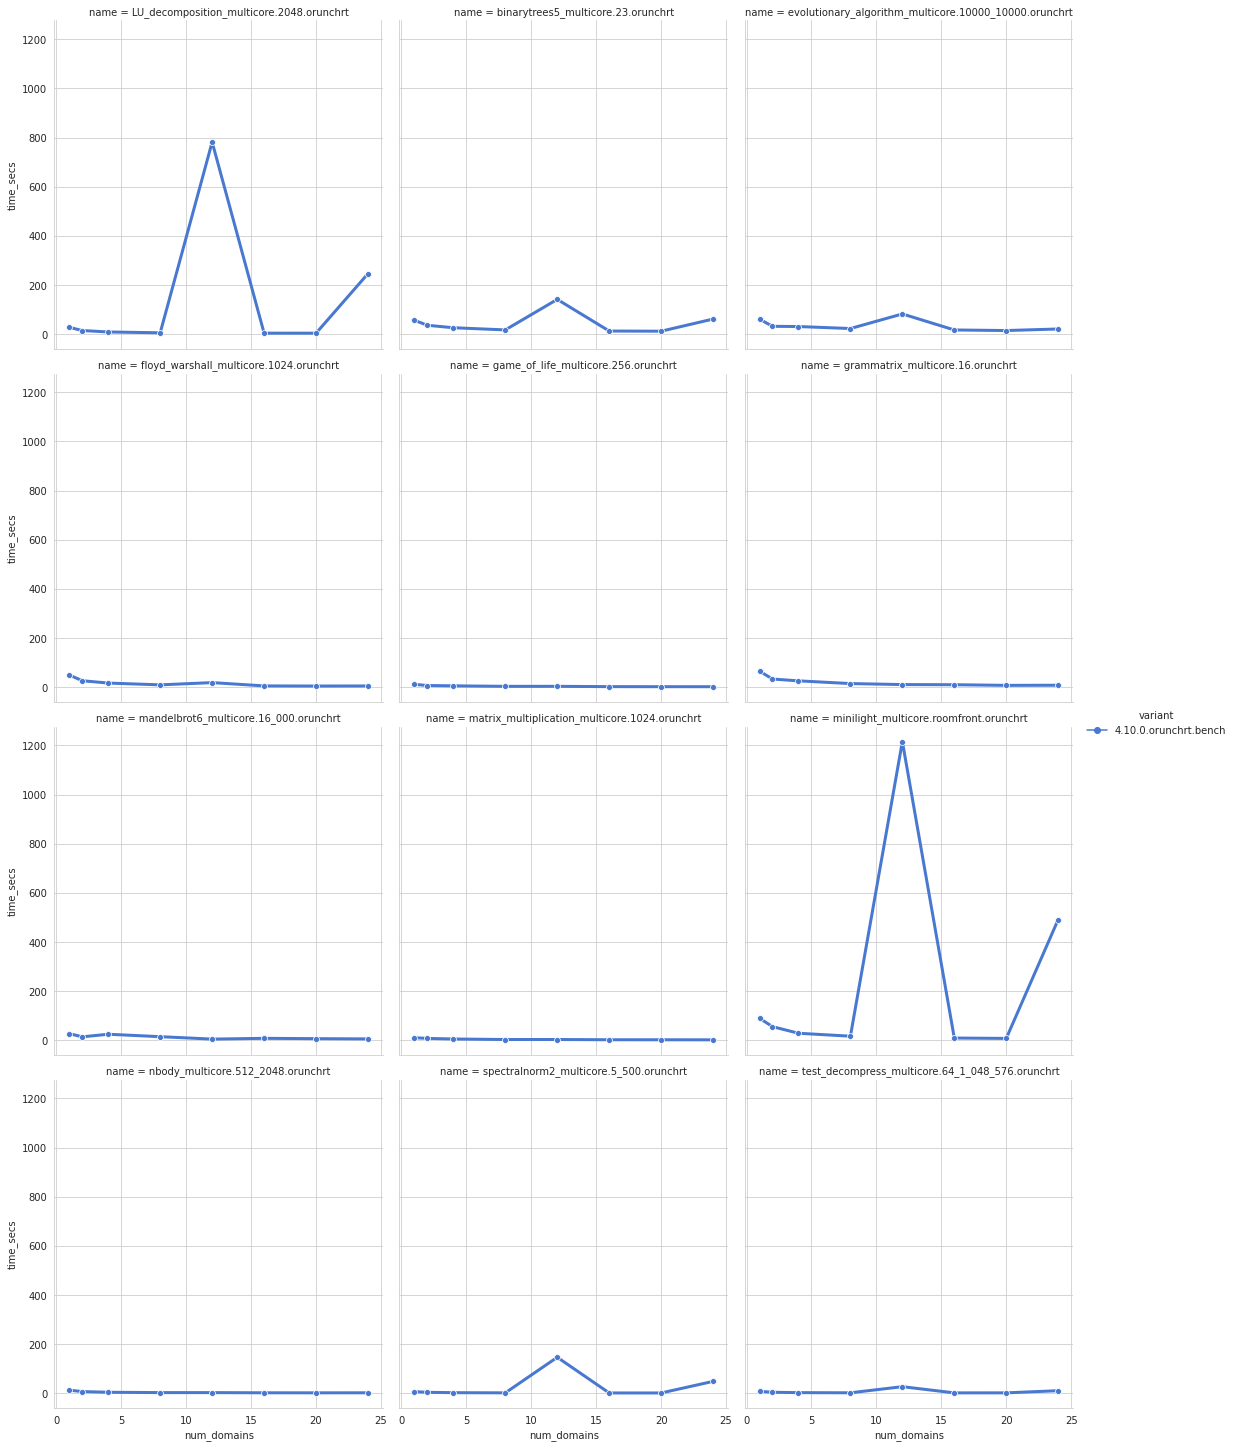

In [94]:
mdf = mdf.sort_values(['name'])
sns.relplot(x='num_domains', y = 'time_secs', hue='variant', col='name',
            data=mdf, kind='line', style='variant', markers=True, col_wrap = 3, 
            lw=3, palette="muted")

## Speedup

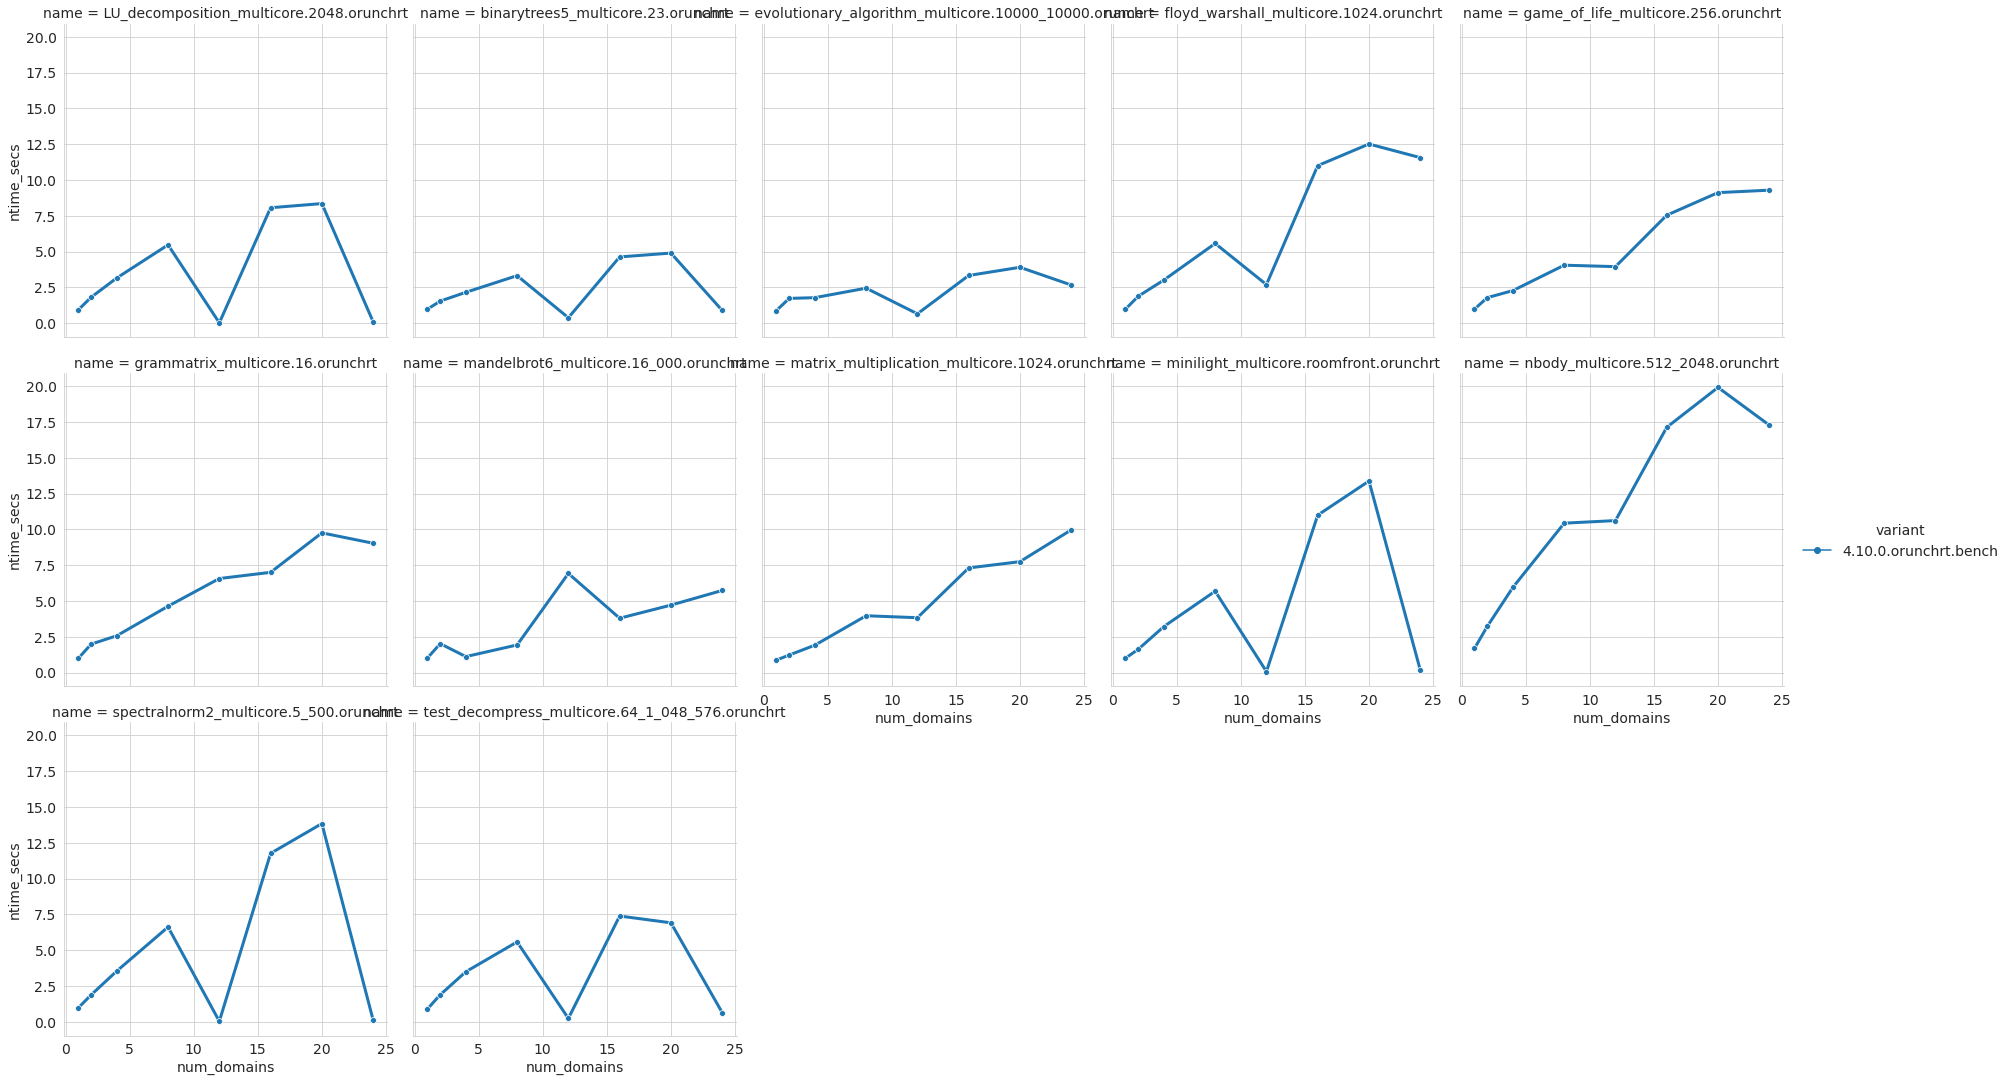

In [95]:
mdf = mdf.sort_values(['name'])
with sns.plotting_context(rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,
                              "legend.fontsize":14}):
    sns.relplot(x='num_domains', y = 'ntime_secs', hue='variant', col='name',
                data=mdf, kind='line', style='variant', markers=True, col_wrap = 5, 
                lw=3)


## Latency

In [96]:
pause_files = []

for root, dirs, files in os.walk(artifacts_dir):
    for file in files:
        if file.endswith(".pausetimes_multicore.bench"):
            # print(root)
            f = root.split("/artifacts/")[1]
            # print(f)
            if (len (f.split("/")) <= 5):
                pause_files.append((os.path.join(root, file)))

In [97]:
len(pause_files)

2

In [98]:
nd = nested_dict(2, list)
for x in pause_files:
    l = x.split("/artifacts/")[1]
    d = l.split("/")
    host      = d[0]
    repo      = d[1]
    commit    = d[2]
    variant   = d[3]
    timestamp = d[4]
    ocaml     = d[5]
    value      = commit + " " + variant + " " + timestamp + " " + ocaml
    nd[host][repo].append(value)
pauses = nd.to_dict()    

In [99]:
pauses

{'spock.ocamllabs.io': {'ocaml_4.06__4.06': ['3e7532a49accb2b09fc2b4cec03c687247c48596 vanilla 20191012_032350 4.06.1+multicore+stw+pausetimes+parallel.pausetimes_multicore.bench',
   '04bceec6cc14f3f7aeff330c69dcbf6d2fa76562 vanilla 20191011_054560 4.06.1+multicore+pausetimes+parallel.pausetimes_multicore.bench']}}

In [100]:
def g(x):
    return x

In [101]:
pause_comparisons = interactive(g, x=widgets.IntText(value=2, 
                                                 description='Comparisons', 
                                                 disabled=False))
display(pause_comparisons)

interactive(children=(IntText(value=2, description='Comparisons'), Output()), _dom_classes=('widget-interact',…

In [102]:
print(pause_comparisons.result)

2


In [103]:
pause_matrix = [[0 for x in range(4)] for y in range(pause_comparisons.result)]
    
for i in range(pause_comparisons.result):
    pause_matrix[i][0], pause_matrix[i][1], pause_matrix[i][2] = disp(pauses)

Box(children=(interactive(children=(Dropdown(description='Host', options=('spock.ocamllabs.io',), value='spock…

Box(children=(interactive(children=(Dropdown(description='Host', options=('spock.ocamllabs.io',), value='spock…

In [104]:
for i in range(pause_comparisons.result):
    pause_matrix[i][3] = get_filename(pauses, pause_matrix[i][0], pause_matrix[i][1], pause_matrix[i][2])

../interactive/test/artifacts/spock.ocamllabs.io/ocaml_4.06__4.06/3e7532a49accb2b09fc2b4cec03c687247c48596/vanilla/20191012_032350/4.06.1+multicore+stw+pausetimes+parallel.pausetimes_multicore.bench
../interactive/test/artifacts/spock.ocamllabs.io/ocaml_4.06__4.06/04bceec6cc14f3f7aeff330c69dcbf6d2fa76562/vanilla/20191011_054560/4.06.1+multicore+pausetimes+parallel.pausetimes_multicore.bench


In [105]:
for i in range (pause_comparisons.result):
    print(pause_matrix[i][3])
    selected_pauses.append(pause_matrix[i][3])

../interactive/test/artifacts/spock.ocamllabs.io/ocaml_4.06__4.06/3e7532a49accb2b09fc2b4cec03c687247c48596/vanilla/20191012_032350/4.06.1+multicore+stw+pausetimes+parallel.pausetimes_multicore.bench
../interactive/test/artifacts/spock.ocamllabs.io/ocaml_4.06__4.06/04bceec6cc14f3f7aeff330c69dcbf6d2fa76562/vanilla/20191011_054560/4.06.1+multicore+pausetimes+parallel.pausetimes_multicore.bench


In [106]:
if enable_gui == False:
    for i in selected_pauses:
        commit_list = i[2].split(" ")
        selected_pauses.append(os.path.join(artifacts_dir, i[0], i[1], '/'.join(commit_list)))

In [107]:
data_frames = []

for file in selected_pauses:
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        df = pdjson.json_normalize(data)
        df['variant'] = file.replace(".pausetimes_multicore.bench","")
        data_frames.append(df)

df2 = pd.concat(data_frames, sort=False)

mdf2 = df2.loc[df2['name'].str.contains('.*multicore.*',regex=True),:]
mdf2['num_domains'] = mdf2['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
mdf2['num_domains'] = pd.to_numeric(mdf2['num_domains'])
mdf2['name'] = mdf2['name'].replace('\..*?_','.',regex=True)

latency_df = pd.DataFrame.copy(mdf2)
mdf2.sort_values(["name"])

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/tljh/user/lib/python3.7/site-packages/ipykernel

,name,mean_latency,max_latency,distr_latency,variant,num_domains
0,LU_decomposition_multicore.2048,1.466052e+04,1984742,"[59, 180, 12030, 13981, 15188, 16062, 17160, 1...",../interactive/test/artifacts/spock.ocamllabs....,12
41,LU_decomposition_multicore.2048,2.193031e+04,2047681,"[59, 75, 273, 21929, 24360, 26420, 28646, 3138...",../interactive/test/artifacts/spock.ocamllabs....,20
67,LU_decomposition_multicore.2048,2.977826e+03,1989167,"[685, 1153, 1205, 1259, 1322, 1414, 1973, 5157...",../interactive/test/artifacts/spock.ocamllabs....,4
63,LU_decomposition_multicore.2048,2.597307e+03,2171641,"[1148, 1213, 1267, 1313, 1350, 1393, 1487, 384...",../interactive/test/artifacts/spock.ocamllabs....,2
63,LU_decomposition_multicore.2048,9.582130e+03,2039512,"[6061, 6347, 7067, 7323, 7757, 8864, 10306, 12...",../interactive/test/artifacts/spock.ocamllabs....,2
67,LU_decomposition_multicore.2048,1.041016e+04,2006313,"[5607, 6900, 7411, 8100, 8967, 10229, 11113, 1...",../interactive/test/artifacts/spock.ocamllabs....,4
41,LU_decomposition_multicore.2048,8.400926e+03,3215850,"[240, 930, 1407, 1929, 2778, 5686, 7204, 9602,...",../interactive/test/artifacts/spock.ocamllabs....,20
87,LU_decomposition_multicore.2048,1.196541e+04,2051519,"[73, 8001, 9006, 10396, 11605, 12278, 13047, 1...",../interactive/test/artifacts/spock.ocamllabs....,8
0,LU_decomposition_multicore.2048,4.931000e+03,2456589,"[496, 876, 1393, 1618, 1906, 2768, 6210, 7302,...",../interactive/test/artifacts/spock.ocamllabs....,12
28,LU_decomposition_multicore.2048,6.897608e+03,201619,"[6130, 6167, 6196, 6224, 6255, 6296, 6366, 652...",../interactive/test/artifacts/spock.ocamllabs....,1


## Max Latency

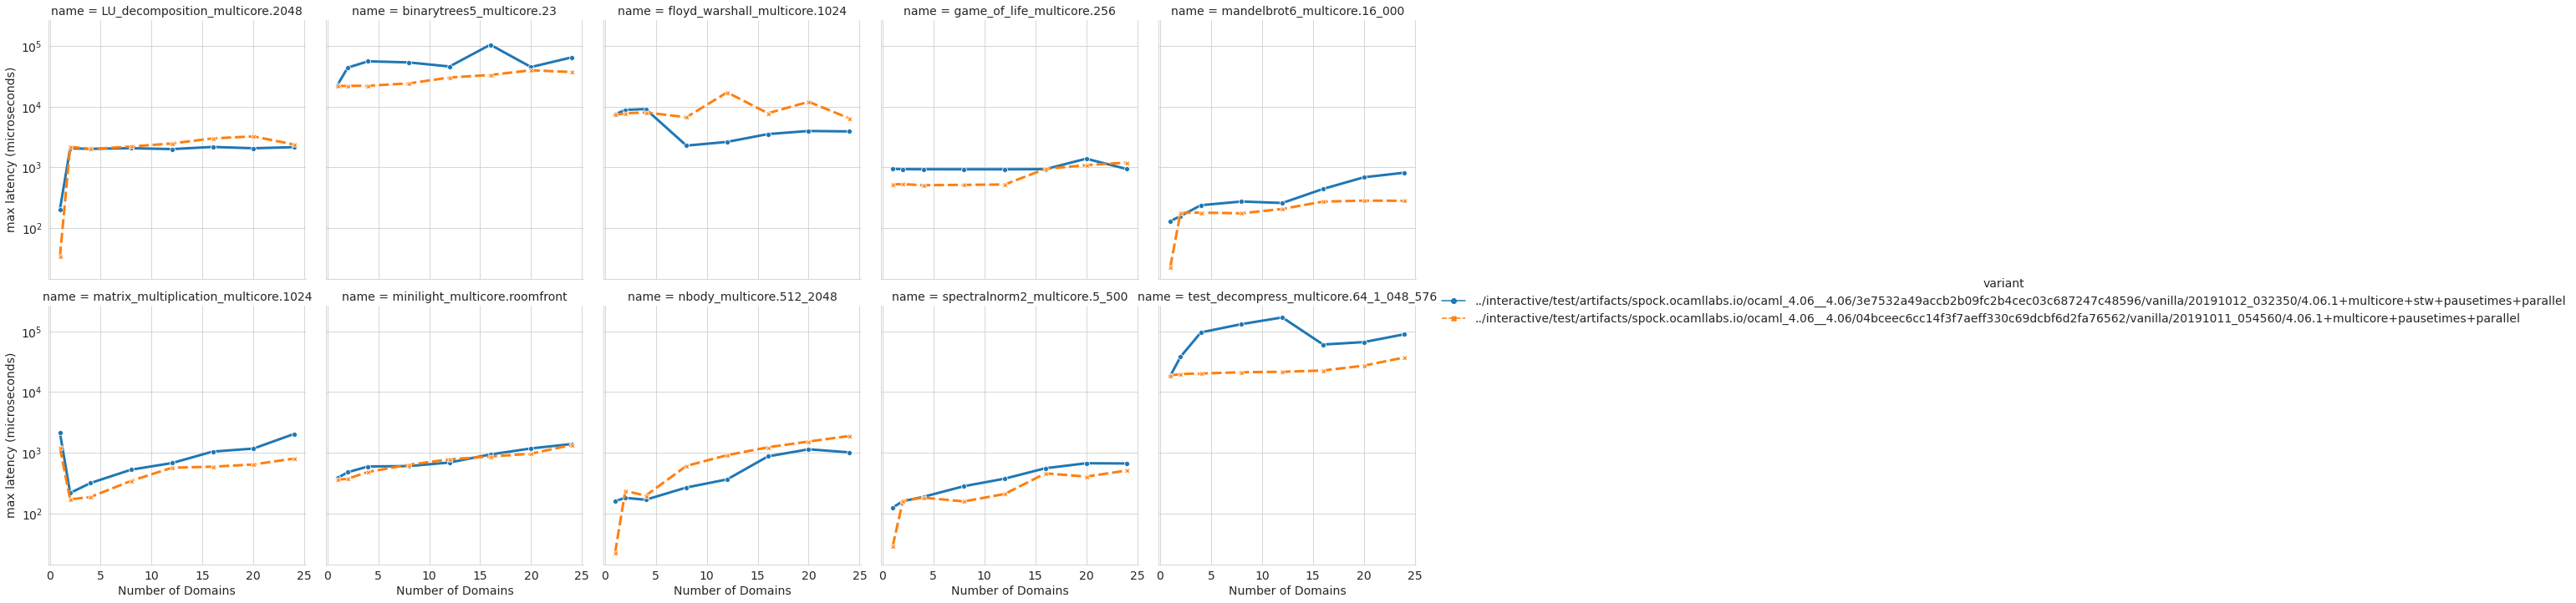

In [108]:
def plotLatencyAt(df,at):
    fdf = df.filter(["name","variant",at + "_latency","num_domains"])
    fdf.sort_values(by="name",inplace=True)
    fdf[at + "_latency"] = fdf[at + "_latency"] / 1000.0
    with sns.plotting_context(rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,
                                  "legend.fontsize":14}):
        g = sns.relplot(x='num_domains', y = at + '_latency', hue='variant', col='name',
                        data=fdf, kind='line', style='variant', markers=True, col_wrap = 5, lw=3)
        for ax in g.axes:
            ax.set_ylabel(at + " latency (microseconds)")
            ax.set_xlabel("Number of Domains")
            ax.set_yscale('log')
        
plotLatencyAt(mdf2,"max")

## 99.9th percentile latency

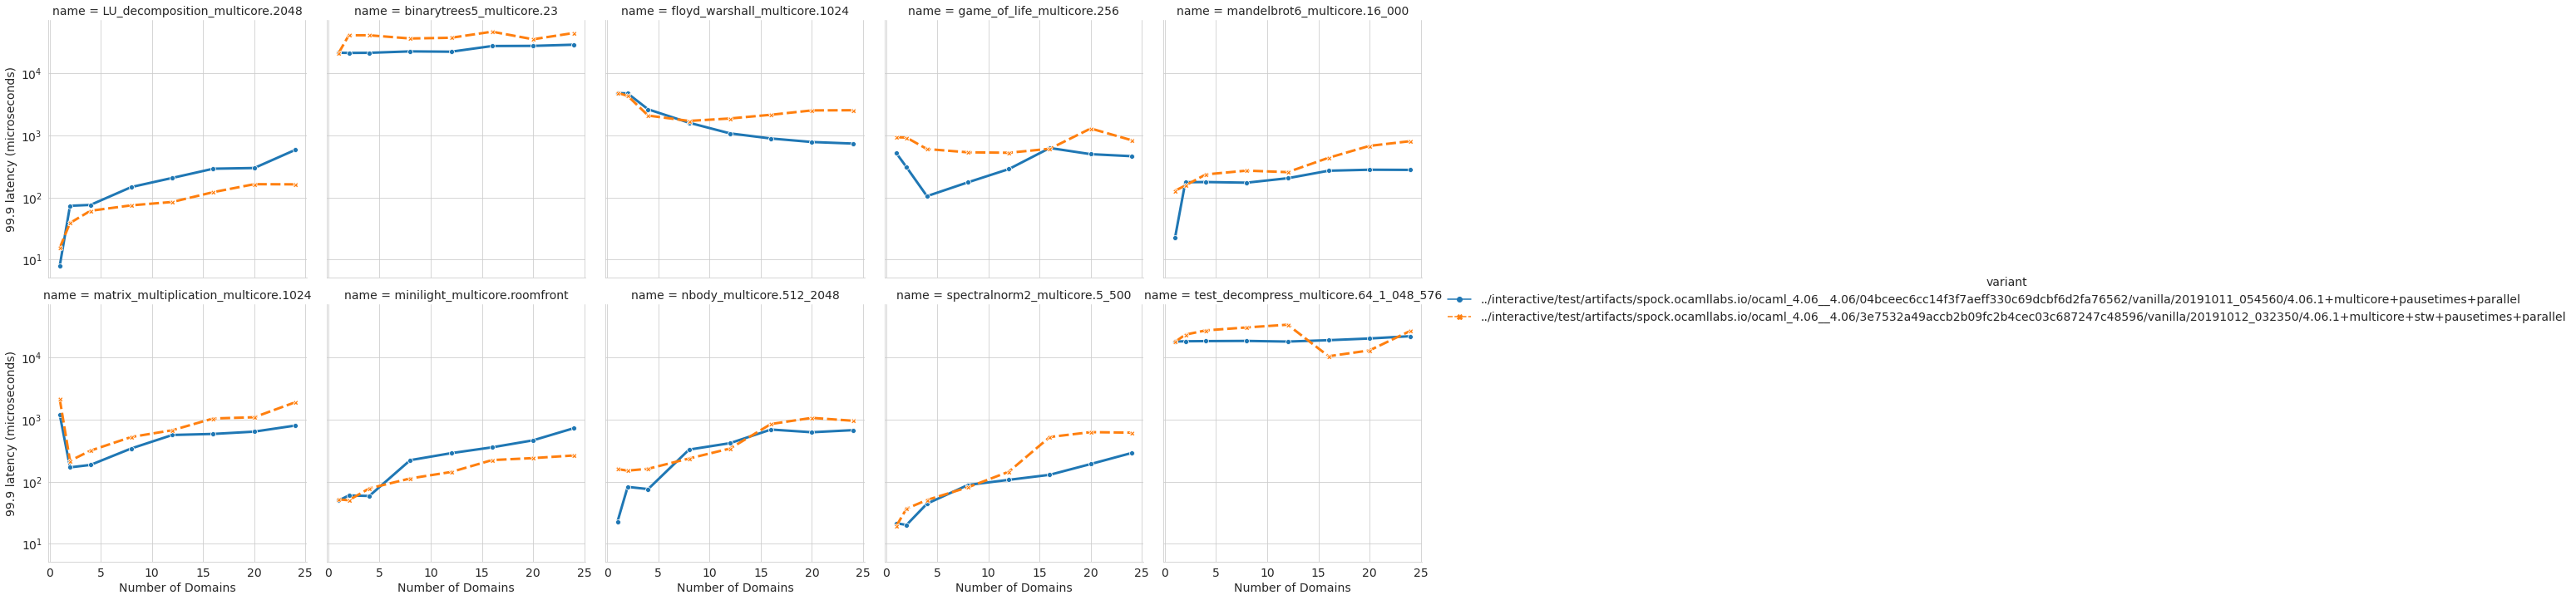

In [109]:
def getLatencyAt(df,percentile,idx):
    groups = df.groupby('variant')
    ndfs = []
    for group in groups:
        (v,df) = group
        for i, row in df.iterrows():
            df.at[i,percentile+"_latency"] = list(df.at[i,"distr_latency"])[idx]
        ndfs.append(df)
    return pd.concat(ndfs)

mdf2 = getLatencyAt(mdf2,"99.9",-1)
plotLatencyAt(mdf2,"99.9")

## 99th percentile latency

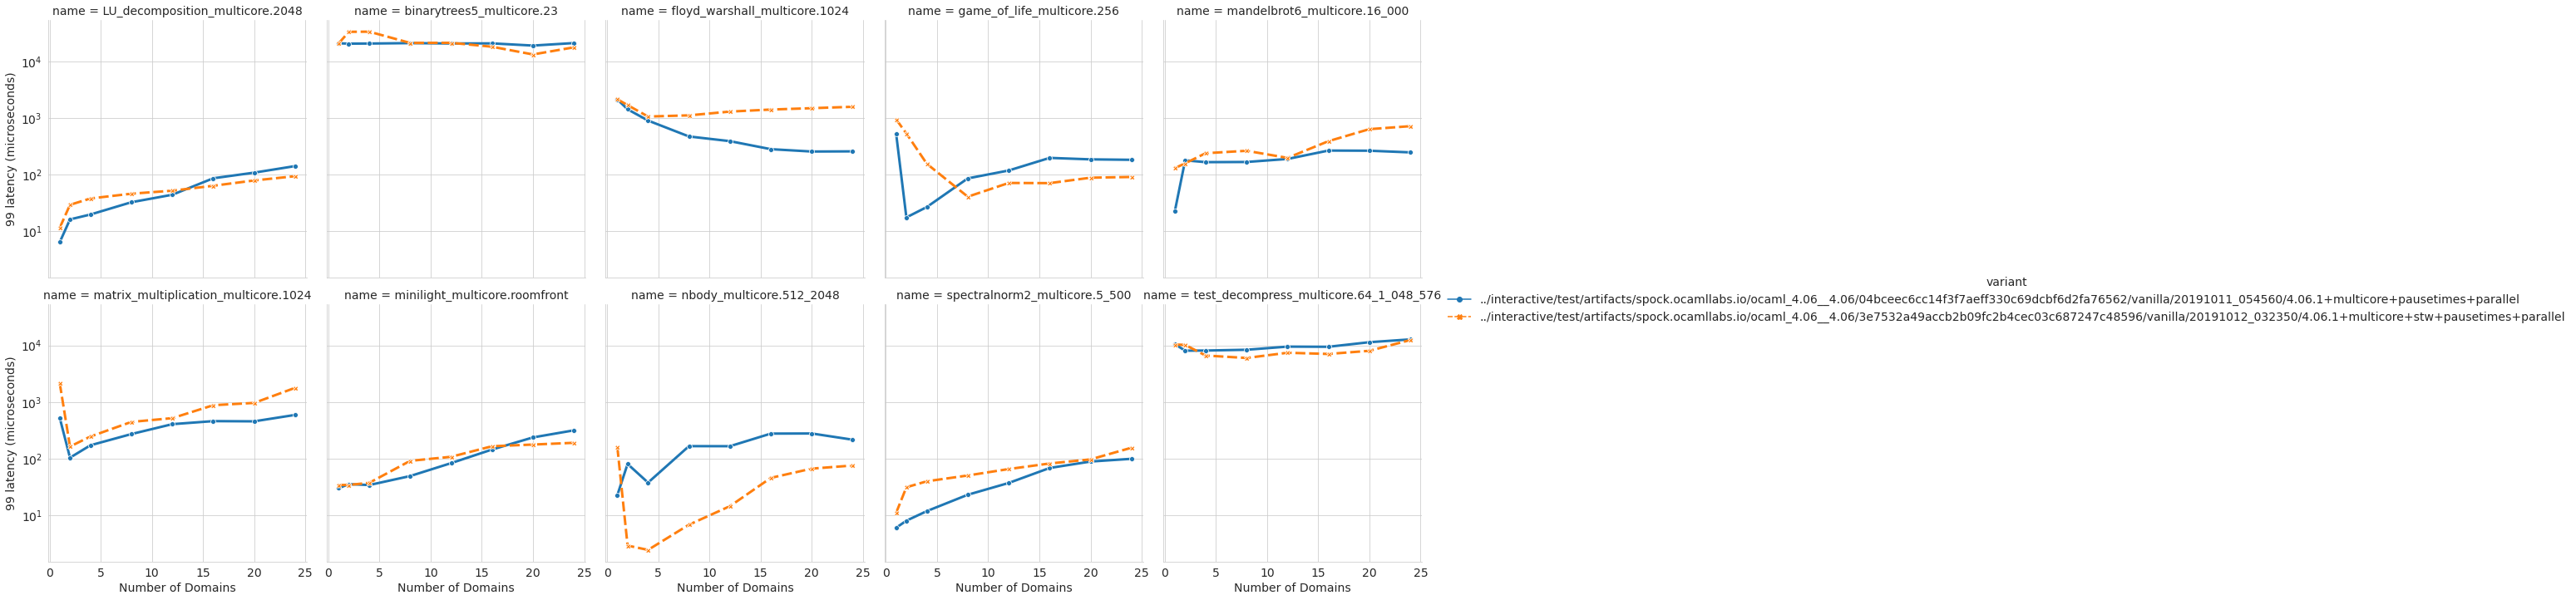

In [110]:
mdf2 = getLatencyAt(mdf2,"99",-2)
plotLatencyAt(mdf2,"99")

## Mean latency

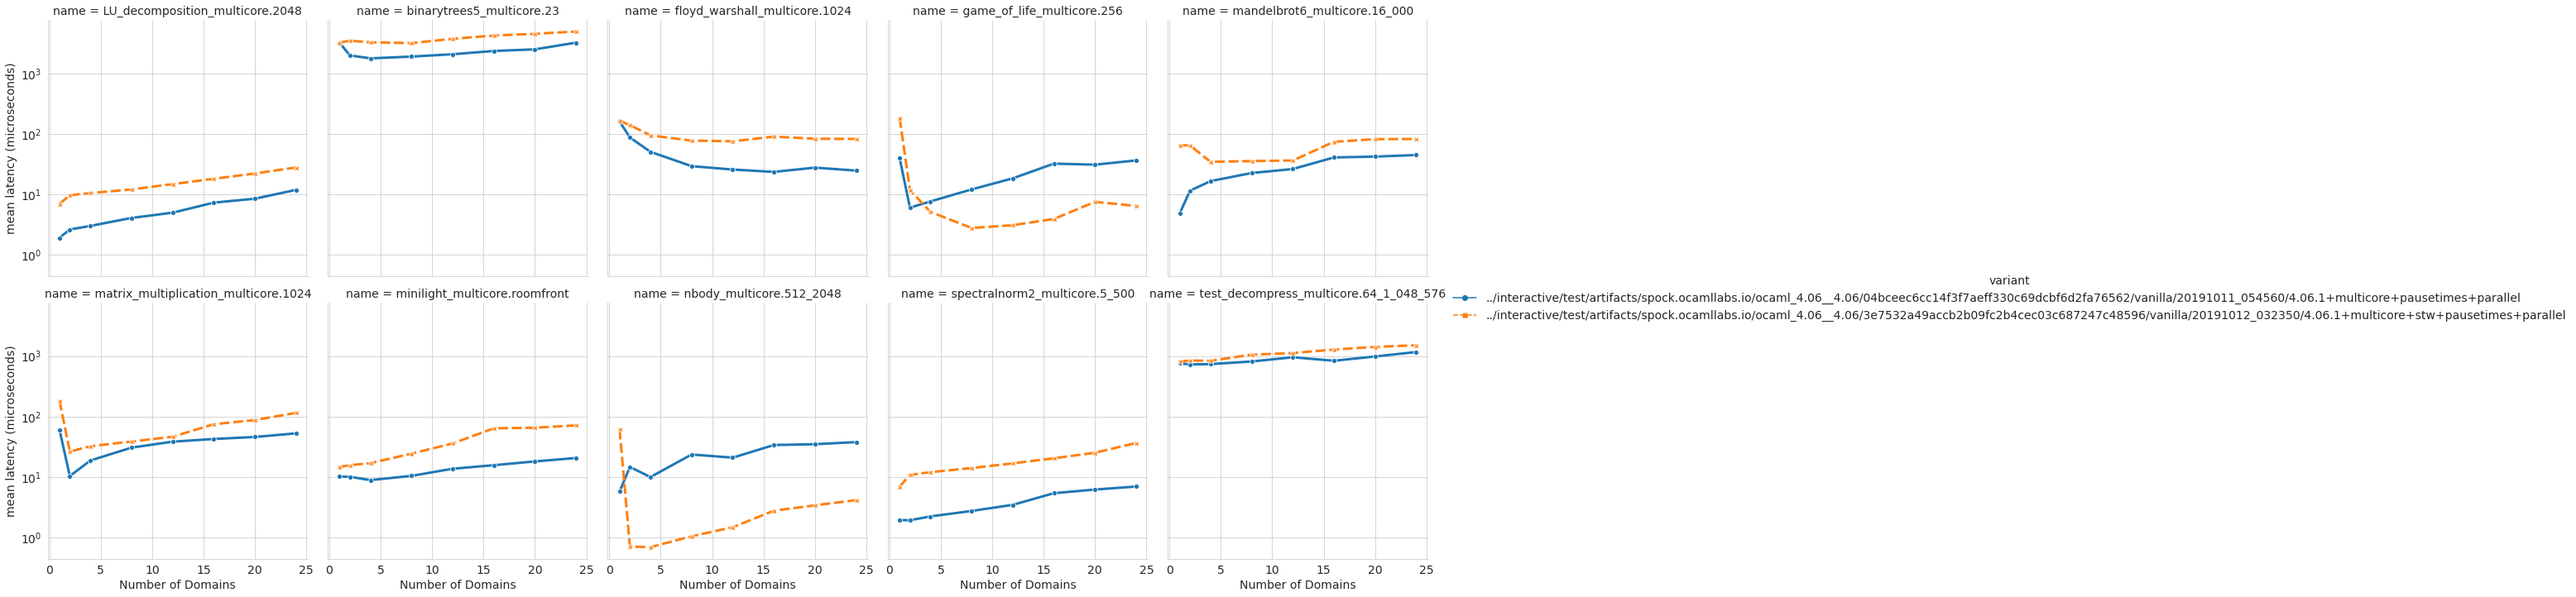

In [111]:
plotLatencyAt(mdf2,"mean")